In [2]:
#some style formatting
from IPython.display import HTML
style = '''<style>
div.abstract_text {text-align: justify;text-justify: inter-word;}
div.text {text-align: justify; text-justify: inter-word;}
</style>'''
HTML(style)


<img typeof="foaf:Image" src="static/ANTI-INFECTIVES-RGB_200pc.png" alt="Wellcome Centre for Anti-Infectives Research" title="">

# ML Analysis for <i>T. brucei</i>

Michele Tinti and Michael A.J. Ferguson

Wellcome Centre for Anti-Infectives Research
School of Life Sciences, University of Dundee

## Abstract
<span>
<div class=abstract_text>
The number of Proteomics and Genomics experiments performed in laboratories is growing exponentially year after year. This massive amount of data poses new challenges to the scientific community. In particular, the amount of available data is not matched by the capacity of bioinformatics tools for retrieving and extracting useful insights from the publicly accessible datasets. On the other hand, machine learning can mitigate this issue by providing powerful analysis tools. However, data needs to be prepared and formatted for machine learning analysis. In this paper, we share with the Trypanosome community a series of Jupyter notebooks to demonstrate the utility of machine learning applied to the analysis of the OMIC experiments produced in our laboratory or deposited at the TryTripDB database.
</div> 
    
## Motivation
<span>
<div class=text>
It remains challenging to analyse and extract information from OMIC experiments. With this work, we share a series of Jupyter notebooks to facilitate the use of machine learning and gain relevant information from OMICs dataset deposited at the TryTripDB. 
</div> 

In [3]:
#set up code
%load_ext autoreload
%autoreload 2

In [4]:
from mylib import scripts
%run mylib/scripts.py
np.random.seed =1976

Using TensorFlow backend.


## Methods

<span>
<div class=text>
Several OMICSs datasets deposited at TriTrypDB cannot immediately be used to annotate a gene function, even if the dataset itself carries useful information. For example, our laboratory and others performed Proteomics experiments to quantify the amount of protein expressed in the BSF and PCF life stages of T. brucei [8-11]. These experiments can be used to create continuous response variables or biological descriptor (feature) reporting the relative fold change in expression between the BSF and PCF life stages. However, the decision boundaries between what is preferentially expressed in PCF or BSF life stages is arbitrary, hampering the creation of a gene set based on such property. On the other hand, Machine Learning (ML) algorithms are potentially able to identify associations between gene sets and biological features by automatically selecting such decision boundaries [12]. For this reason, we decided to extract biological features from the OMICs experiments deposited at TriTrypDB to create a ML dataset for T. brucei.    
</div> 

## Start

## Download the dataset
We used all the gene identifiers of T. brucei TREU927 clone to query the TriTrypDB database version 44. The search strategy used for this step is available at theTriTrypDB database with the accession identifier d7c5277bb3cfbf2d (https://tritrypdb.org/tritrypdb/im.do?s=d7c5277bb3cfbf2d). From the TriTrypDB interface, we downloaded all the available information for this search strategy into a comma-separated values (CSV) file. Broadly speaking, this step assembles a collection of Proteomics, Transcriptomics (RNA-seq / gene chip) and genomics dataset along with several protein sequence descriptors, such as the presence of a signal peptide, the counts of transmembrane domain or the genomic location of the protein gene.
### select the option indicated on the red arrows 
<img typeof="foaf:Image" src="static/Capture_2.PNG" alt="Wellcome Centre for Anti-Infectives Research" title="">



In [4]:
import pandas as pd
#load the dataset
#final_df = pd.read_csv('indata/GenesByTaxon_Summary_43.zip',sep='\t')
tryp_df = pd.read_csv(os.path.join('input','GenesByTaxon_Summary_45.zip'), sep='\t')
tryp_df.head()
print(tryp_df.shape)

(11832, 597)


### Time to create the ML dataset

In [5]:
#this is our ML dataset, ready to accept new features
ml_df = tryp_df[['Gene ID']].copy()

In [6]:
#There is a bug in the tritrypDB script that create the outputs
#some RNA-seq experiments have the same name for unique and nonunique values
#pandas assign to such duplicates column the '.1' suffix
len([n for n in tryp_df.columns if '.1' in n])
#also, some RNA-seq experiments are still missing the unique and nonunique tag

3






## Processing of proteomics data
### BSF PCF fold change

TryTripDB contains 6 proteomic datasets that analyse  the differential protein expression between the Procyclic form (PCF) and BloodStream form (BSF) parasites stages. Two datasets (<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_cb23da819c">Urbaniak 2012</a>  and <a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_24b68cb68a">Urbaniak 2013</a>) were produced in our research centre and two others were reported in <a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_1ec24003f1">Butter et al. 2013</a>. Two other experiments were produced by <a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_1e1fb1711d">Gunasekera K et al 2012 </a> differentiating between Long Slender (LS) and  Short Stumpy (SS) BSF life stage.
We now aim to visualize the similarities between these datasets.


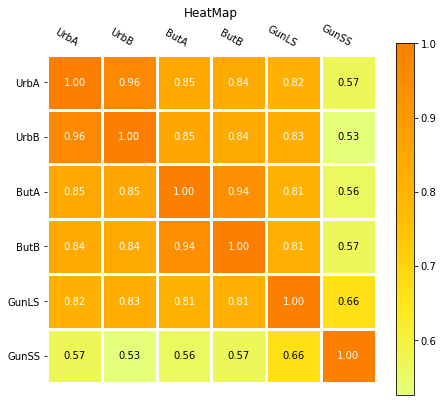

In [7]:
#columns with the data
proteomics_columns = ['Procyclic Form Vs Bloodstream Form (Tb PCFvBSF QProt SILAC)',
                     'Pcf-Bsf ratio (Tb PCF BSF QPhosProt)',
                    'Combined-PCF_light V BSF_heavy (Tb PCF BSF Prot SILAC-switch)',
                    'Combined-PCF_heavy V BSF_light (Tb PCF BSF Prot SILAC-switch)',
                         'LS (Tb927 LSvSS QProt)',
                         'SS (Tb927 LSvSS QProt)',]

rename = ['UrbA', 'UrbB', 'ButA', 
          'ButB','GunLS','GunSS']
#rename = ['1', '2', '3', '4']
temp_df = tryp_df[proteomics_columns]
temp_df.columns = rename

im, cbar, ax = scripts.heatmap(temp_df.corr().values,
                           temp_df.columns,temp_df.columns,cmap="Wistia")

texts = scripts.annotate_heatmap(im, valfmt="{x:.2f}")
plt.tight_layout()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 6)
plt.title('HeatMap')
#ax.set_xticks([]) 
#ax.set_yticks([]) 
#ax.tick_params(axis=u'both', which=u'both',length=0)
#plt.savefig(os.path.join('figures','example_1','Fig_1a.png'))
plt.show()

The figure plots an heatmap of the Pearson correletion coefficents between the proteomic experiments. The five datasets using the LS BSF life stage showed good experimental reproducibility (above 0.8). Unsurprising, the experiment using the SS BSF life stage showed a lower reproducibility with the other five experiments; for this reason, this experiment was removed and used to create a different biological descriptor. On the other hand, we averaged the experiments using the LS BSF life stage in one descriptor, after normalization using the z-scores, necessary step to avoid redundancy in the ML dataset. 

In [8]:
ss = StandardScaler()
del temp_df['GunSS']
temp_df=pd.DataFrame(ss.fit_transform(temp_df), 
                     columns=temp_df.columns,index=temp_df.index.values)
temp_df['merged']=temp_df.median(axis=1, skipna=True)

#### BSF PCF missing data

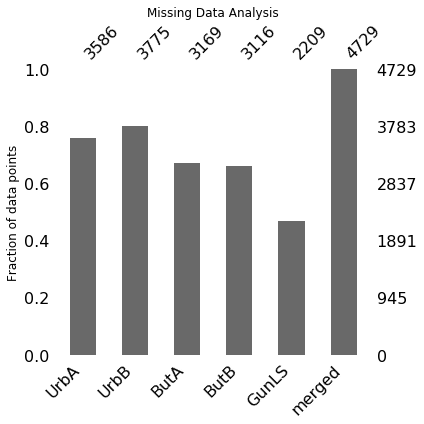

In [9]:
#visualization of missing data
ax=msno.bar(temp_df.dropna(axis=0, how='all'),figsize=(6, 6))
plt.title('Missing Data Analysis',size=12)
ax.set_ylabel('Fraction of data points',size=12)
#plt.xtickslabels(fontsize=12)
plt.tight_layout()
#plt.savefig(os.path.join('figures','example_1','Fig_2.png'))
plt.show()

The merged dataset has less missing data points

In [10]:
#adding our merged feature
ml_df['EF_merged_PCF_BSF']=temp_df['merged'].values
ml_df['SS (Tb927 LSvSS QProt)']=tryp_df['SS (Tb927 LSvSS QProt)']
print(ml_df.shape)

#removing old stuff
del temp_df
gc.collect()

(11832, 3)


50

### PCF Cell Cycle
Further descriptors were engineered from the changes in abundance of the PCF proteome during the cell cycle progression [17]. From this time-course experiment, we extracted two categorical features and one continuous variable. The two categorical features reported the time point (hour) showing the maximum abundance value (MAX) and the time point showing the minimum abundance value (MIN) for each protein in the time-course experiment. The continue variable consisted of the log2 fold change between the MAX and MIN protein abundance values across the time-course experiment. The same feature extraction strategy was further applied to the time course experiments studying the changes in proteome and transcriptome abundance during the T. brucei differentiation from the BSF to PCF life stage [8, 18-22]. 

In [11]:
list(tryp_df.columns)
#final_df[[n for n in final_df.columns  if 'Tb LifeCyc Marray' in n]].head()
cols = [n for n in tryp_df.columns  if 'Tb procyclic cell cycle proteome' in n]
print (cols)
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_CellCycle_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))
ml_df['EF_CellCycle_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_CellCycle_max'] = [float(str(n).split(' ')[0]) for n in ml_df['EF_CellCycle_max']]
ml_df['EF_CellCycle_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_CellCycle_min'] = [float(str(n).split(' ')[0]) for n in ml_df['EF_CellCycle_min']]

['0.5 hr (Tb procyclic cell cycle proteome)', '3 hr (Tb procyclic cell cycle proteome)', '5 hr (Tb procyclic cell cycle proteome)', '6 hr (Tb procyclic cell cycle proteome)', '7 hr (Tb procyclic cell cycle proteome)', '8 hr (Tb procyclic cell cycle proteome)', '9 hr (Tb procyclic cell cycle proteome)', '10 hr (Tb procyclic cell cycle proteome)', '11 hr (Tb procyclic cell cycle proteome)']


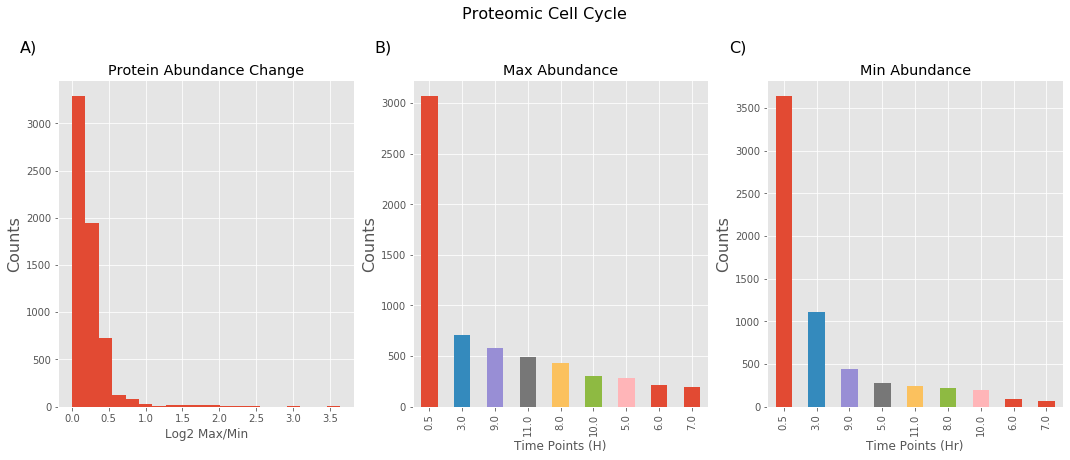

In [12]:
plt.style.use('ggplot')
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_CellCycle_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_CellCycle_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_CellCycle_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (Hr)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('Proteomic Cell Cycle',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_3.png'))
plt.show()

### BSF / PCF Protein Abundance
We also decided to create an absolute protein abundance feature in BSF and PCF by using a recent experiment published by our laboratory [13]. This dataset (not yet uploaded in TryTripDB), is available from the public repository Zenodo [14] and uses the SILAC technique to study the turnover rate of the T. brucei BSF and PCF proteomes. In this work, fully label BSF and PCF parasites growth in medium SILAC culture media (M) were placed in light SILAC culture media (L) to follow the synthesis and degradation rate of the proteome with a time-course experiment. The experiment consisted of seven and nine time points for the BSF and PCF respectively with three biological replicas each. The samples of the time course experiment were also mixed 1:1 with fully label parasites in heavy SILAC culture media (H) to provide an internal standard for normalization. The log10 protein intensity values of the H samples were used as a proxy for protein abundance after averaging H intensity values of each protein across the biological replica and the time points. 


In [13]:
bsf = pd.read_table(os.path.join('input','turnover','BSF','proteinGroups.zip'))
pcf = pd.read_table(os.path.join('input','turnover','PCF','proteinGroups.zip'))

intensity_columns = [n for n in bsf.columns if n.startswith('Intensity H') ]
bsf[intensity_columns]=bsf[intensity_columns].replace(0,np.nan)
bsf['abundance'] = np.log10(bsf[intensity_columns].mean(axis=1,skipna=True))

intensity_columns = [n for n in pcf.columns if n.startswith('Intensity H') ]
pcf[intensity_columns]=pcf[intensity_columns].replace(0,np.nan)
pcf['abundance'] = np.log10(pcf[intensity_columns].mean(axis=1, skipna=True))


temp_dict = scripts.make_dict_from_cols(bsf)
ml_df['EF_Abundance_BSF']=[temp_dict.get(n, np.nan) for n in tryp_df['Gene ID']]
temp_dict = scripts.make_dict_from_cols(pcf)
ml_df['EF_Abundance_PCF']=[temp_dict.get(n, np.nan) for n in tryp_df['Gene ID']]
print(ml_df.shape)

(11832, 8)


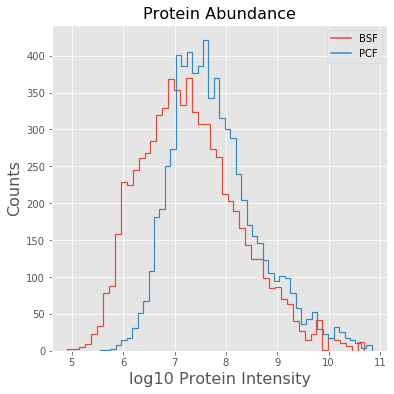

In [14]:
fig,ax=plt.subplots(figsize=(6,6))
from matplotlib.lines import Line2D
ml_df['EF_Abundance_BSF'].plot(kind='hist',histtype='step', ax=ax, label='BSF',linewidth=1.2,bins=50)
ml_df['EF_Abundance_PCF'].plot(kind='hist',histtype='step', ax=ax, label='PCF',linewidth=1.2,bins=50)
plt.xlabel('log10 Protein Intensity', fontsize=16)
plt.ylabel('Counts', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)
plt.title('Protein Abundance',fontsize=16)
#plt.savefig(os.path.join('figures','example_1','Fig_4.png'))
plt.show()

### PCF Protein Complexes

A further experiment from our laboratory (not yet uploaded in TriTrypDB) aimed at the identification of T. brucei protein complexes using size-exclusion chromatography (SEC) and mass spectrometry [15]. Briefly, PCF cells were prepared for native protein complex analysis by sonication lysis. The resulting lysates were fractionated separating protein complexes based on their size and shape, and the fractions were analysed by mass spectrometry. From this dataset, we first focus on the experiment using the 30 nm pore column (SEC 300), that efficiently separates protein complexes in the range from 8 kDa to 1.2 MDa. Thanks to protein molecular weight (MW) standards, it is then possible to infer the apparent MW of protein in each of the SEC 300 elution fractions. Consequently, we assign to each protein an apparent MW corresponding to the fraction showing the maximum protein abundance. The log2 fold change between the apparent MW and the MW of the protein computed from the primary sequence was taken as a descriptor to describe the molecular state of protein, in high MW complexes (log2 fold change > 0), monomer (log2 fold change around 0) or degraded (log2 fold change < 0). Finally, we created a simple binary feature describing if a protein is part (1) or not (0) of a complex based on the analysis reported in Crozier TWM et al. [15].

In [15]:
#regression to compute the predicted MW 
#from the chromatography fraction
def find_weight(f):
    from pylab import polyfit
    from pylab import poly1d
    x = [8, 13, 21, 25, 31, 39, 44]
    y = [np.log(n) for n in [1200,660,450,150,70,21,8]]
    fit = polyfit(x, y, 1)
    fit_fn = poly1d(fit)
    return np.exp(fit_fn(f))

#parse MaxQuant output
infile=os.path.join('input','protein_complexes','proteinGroups_SEC300.zip')
indf = pd.read_table(infile)
temp = indf[[n for n in indf.columns if 'LFQ intensity' in n ]]
#print(temp.shape)
df_list = []
#using dataset with good reproducibility (see paper)
for good_id in ['E3017','E3019','E3021','E3023']:
    temp = indf[[n for n in temp.columns if good_id in n ]]
    temp.columns = [n.split('_')[-1] for n in temp.columns]
    temp['ids']=temp.index.values
    df_list.append(temp)
df_list = pd.concat(df_list)
df_list=df_list.groupby('ids').mean()
df_list['max']=df_list.idxmax(axis=1)
df_list['apparent_weigth'] = [find_weight(int(f)) for f in df_list['max']]
df_list=pd.concat([df_list,indf[['Protein IDs']] ] ,axis=1)
df_list.head()

,01,02,03,04,05,06,07,08,09,10,...,42,43,44,45,46,47,48,max,apparent_weigth,Protein IDs
ids,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,255.832140,CON__A2A5Y0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,189240000.0,48,5.946440,CON__ENSEMBL:ENSBTAP00000007350;CON__P01030
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,63.515795,CON__ENSEMBL:ENSBTAP00000018229;CON__Q3MHN5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01,4150.513573,CON__ENSEMBL:ENSBTAP00000018574
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,678.432213,CON__ENSEMBL:ENSBTAP00000024146


In [16]:
#extract firsth feature
map_dict = scripts.make_dict_from_cols(df_list,
                                       key='Protein IDs', 
                                       value='apparent_weigth')
tryp_df['apparent_weigth']=[map_dict.get(n,np.nan) for n in tryp_df['Gene ID']]
ml_df['EF_MW_fc'] = tryp_df['apparent_weigth']/(tryp_df['Molecular Weight']/1000)


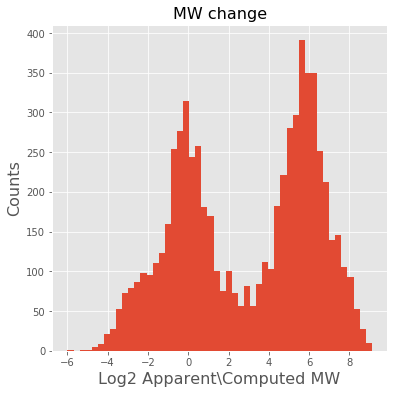

In [17]:
np.log2(ml_df['EF_MW_fc']).plot(kind='hist',figsize=(6,6), bins=50)
plt.title('MW change', fontsize=16)
plt.xlabel('Log2 Apparent\Computed MW',fontsize=16)
plt.ylabel('Counts', fontsize=16)
#plt.savefig(os.path.join('figures','example_1','Fig_5.png'))
plt.show()

In [18]:
ml_df['EF_MW_fc'] = ml_df['EF_MW_fc'].fillna(0)

In [19]:
#extract second feature
#this extract the predicted protein complexes from the paper
temp = open(os.path.join('input', 'protein_complexes', 'final_complexes_mcp.txt'))
complex_set = []
for line in temp:
    prots = line.split('\t')
    prots = [n.strip() for n in prots]
    complex_set+=prots
complex_set=set(complex_set)
ml_df['EF_in_complex'] = [1 if n in complex_set else np.nan 
                          for n in ml_df['Gene ID']]
ml_df['EF_in_complex'].value_counts()
ml_df['EF_in_complex']=ml_df['EF_in_complex'].fillna(-1)

### Differentiation From BSF to PCF
Dejung M, 2016<p>
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/26910529  ">26910529 </a> and <a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_1ec24003f1">TryTripDB</a>



During the life cycle of the African trypanosomes in the mammalian host, the trypanosomes undergo a developmental transition from a rapidly dividing long slender stage (LS) to a non-dividing short stumpy stage (SS). The LS stage is well adapted for growth in the mammalian host whereas the SS stage appears pre-adapted for life in the vector. In this dataset, parasites were induced to differentiate from the short stumpy (SS) form to the procyclic form (PF) using 6 mM citrate/cis-aconitate. Parasites were harvested at 0, 2, 4, 6, 12, 24, and 48 h after treatment, and established PF and long slender (LS) forms were also collected.

<b> The TriTrypDB dataset appears to miss the SS </b> (short stumpy stage) present in the original articles. See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4765897/figure/ppat.1005439.g001/

In [20]:
#i'm going to code the LS stage as -1 hour and PF stage as +100 hour
#as they shuld represent the earliest and the latest time point in the series'
tryp_df.rename({'LS (tbru differ proteome)':
                 '-1 LS (tbru differ proteome)',
                 'PF (tbru differ proteome)':
                 '100 PF (tbru differ proteome)'},
                inplace=True,axis=1)
cols = [n for n in tryp_df.columns  if 'tbru differ proteome' in n]
cols

['-1 LS (tbru differ proteome)',
 '0 hr (tbru differ proteome)',
 '2 hr (tbru differ proteome)',
 '4 hr (tbru differ proteome)',
 '6 hr (tbru differ proteome)',
 '12 hr (tbru differ proteome)',
 '24 hr (tbru differ proteome)',
 '48 hr (tbru differ proteome)',
 '100 PF (tbru differ proteome)']

In [21]:
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_prot_BSF_to_PCF_1_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))
ml_df['EF_prot_BSF_to_PCF_1_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_prot_BSF_to_PCF_1_max'] = [float(str(n).split(' ')[0]) 
                                     for n in ml_df['EF_prot_BSF_to_PCF_1_max']]
ml_df['EF_prot_BSF_to_PCF_1_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_prot_BSF_to_PCF_1_min'] = [float(str(n).split(' ')[0]) 
                                     for n in ml_df['EF_prot_BSF_to_PCF_1_min']]

#ml_df['prot_BSF_to_PCF_1_min']=ml_df['prot_BSF_to_PCF_1_min'].astype('category')
#ml_df['prot_BSF_to_PCF_1_max']=ml_df['prot_BSF_to_PCF_1_max'].astype('category')

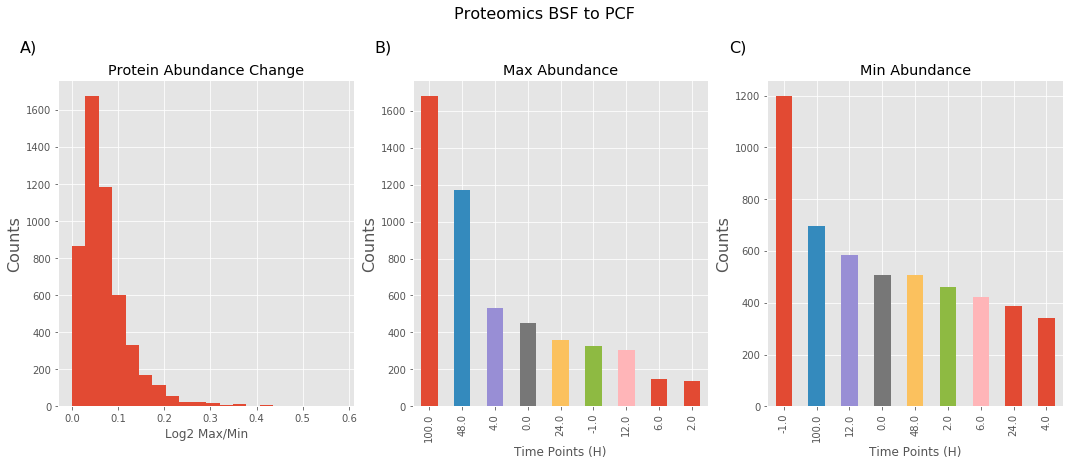

In [22]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_prot_BSF_to_PCF_1_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_prot_BSF_to_PCF_1_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_prot_BSF_to_PCF_1_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('Proteomics BSF to PCF',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_6.png'))
plt.show()

In [23]:
print(ml_df.shape)

(11832, 13)


## Processing of trascriptomics data

### microarray

#### DNA microarray BSF to PCF 1
<p>
Jensen BC et al, 2009

Differentiation from stumpy to tsetse-midgut procyclic forms
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/19840382 ">19840382</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_2e9f1cbf33">TryTripDB</a>

Whole genome comparison of RNA levels for both protein coding genes and structural RNAs in five different life-cycle stages: cultured bloodstream (Blood Form), in vivo slender bloodstream (Slender), in vivo stumpy bloodstream (Stumpy), log-phase procyclic culture (PCF Log) and stationary-phase procyclic culture forms (PCF Stat)   

In [24]:
tryp_df.rename({'Blood Form (Tb LifeCyc Marray)':
                '1 Blood Form (Tb LifeCyc Marray)',
                
                'Slender (Tb LifeCyc Marray)':
                 '2 Slender (Tb LifeCyc Marray)',

                'Stumpy (Tb LifeCyc Marray)':
                 '3 Stumpy (Tb LifeCyc Marray)',

                 'PCF Log (Tb LifeCyc Marray)':
                 '4 Stumpy (Tb LifeCyc Marray)',
                 
                'PCF Stat (Tb LifeCyc Marray)':
                 '5 PCF Stat (Tb LifeCyc Marray)',
                },
                inplace=True,axis=1)

cols = [n for n in tryp_df.columns  if 'Tb LifeCyc Marray' in n]
cols

['1 Blood Form (Tb LifeCyc Marray)',
 '2 Slender (Tb LifeCyc Marray)',
 '3 Stumpy (Tb LifeCyc Marray)',
 '4 Stumpy (Tb LifeCyc Marray)',
 '5 PCF Stat (Tb LifeCyc Marray)']

In [25]:
ml_df['EF_ma_BSF_to_PCF_1_min_max'] = np.log2(
    tryp_df[cols].max(axis=1,skipna=True)/tryp_df[cols].min(axis=1,skipna=True))
ml_df['EF_ma_BSF_to_PCF_1_max'] = tryp_df[cols].idxmax(axis=1)
ml_df['EF_ma_BSF_to_PCF_1_max'] = [float(str(n).split(' ')[0]) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_1_max']]
ml_df['EF_ma_BSF_to_PCF_1_min'] = tryp_df[cols].idxmin(axis=1)
ml_df['EF_ma_BSF_to_PCF_1_min'] = [float(str(n).split(' ')[0]) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_1_min']]

#ml_df['ma_BSF_to_PCF_1_max']=ml_df['ma_BSF_to_PCF_1_max'].astype('category')
#ml_df['ma_BSF_to_PCF_1_min']=ml_df['ma_BSF_to_PCF_1_min'].astype('category')

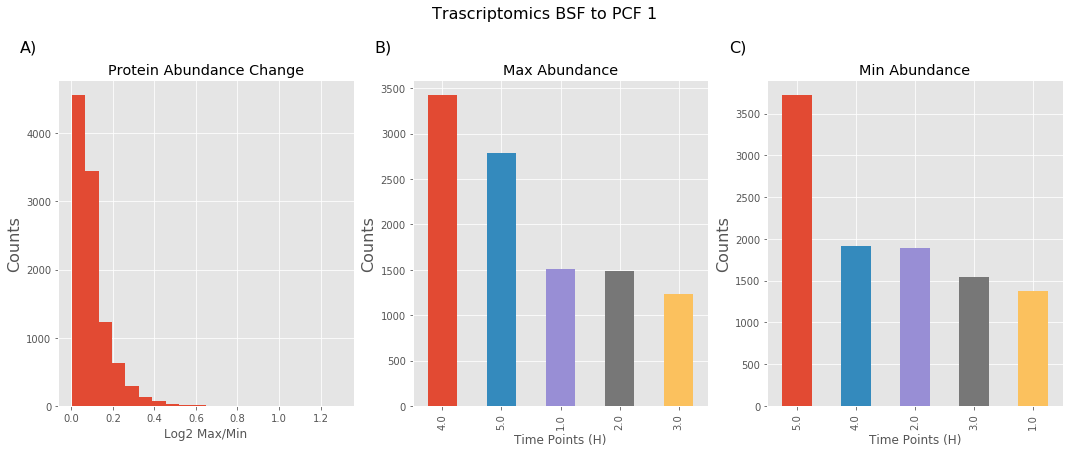

In [26]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_ma_BSF_to_PCF_1_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_ma_BSF_to_PCF_1_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_ma_BSF_to_PCF_1_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('Trascriptomics BSF to PCF 1',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_7.png'))
plt.show()

#### DNA microarray BSF to PCF 2
Queiroz R et al 2009<p>
Gene Expression profiling during in vitro differentiation from cultured bloodstream forms to procyclic forms
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/19857263">19857263</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_0c4be69d67">TryTripDB</a>

In [27]:
tryp_df.rename({'bf-ld (Tb cBSFtoPCF Marray)':
                 '-2 bf-ld (Tb cBSFtoPCF Marray)',
                'bf-hd (Tb cBSFtoPCF Marray)':
                 '-1 bf-hd (Tb cBSFtoPCF Marray)'
                },
                inplace=True,axis=1)

cols = [n for n in tryp_df.columns  if 'Tb cBSFtoPCF Marray' in n]
print (cols)

['-2 bf-ld (Tb cBSFtoPCF Marray)', '-1 bf-hd (Tb cBSFtoPCF Marray)', '0.5hr (Tb cBSFtoPCF Marray)', '1hr (Tb cBSFtoPCF Marray)', '12hr (Tb cBSFtoPCF Marray)', '24hr (Tb cBSFtoPCF Marray)', '48hr (Tb cBSFtoPCF Marray)', '72hr (Tb cBSFtoPCF Marray)']


In [28]:
ml_df['EF_ma_BSF_to_PCF_2_min_max'] = np.log2(
    np.exp(tryp_df[cols].max(axis=1,
                             skipna=True))/np.exp(tryp_df[cols].min(axis=1,
                                                                    skipna=True)))
ml_df['EF_ma_BSF_to_PCF_2_max'] = tryp_df[cols].idxmax(axis=1)
ml_df['EF_ma_BSF_to_PCF_2_max'] = [float(str(n).split(' ')[0].replace('hr','')) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_2_max']]
ml_df['EF_ma_BSF_to_PCF_2_min'] = tryp_df[cols].idxmin(axis=1)
ml_df['EF_ma_BSF_to_PCF_2_min'] = [float(str(n).split(' ')[0].replace('hr','')) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_2_min']]

#ml_df['ma_BSF_to_PCF_2_max']=ml_df['ma_BSF_to_PCF_2_max'].astype('category')
#ml_df['ma_BSF_to_PCF_2_min']=ml_df['ma_BSF_to_PCF_2_min'].astype('category')

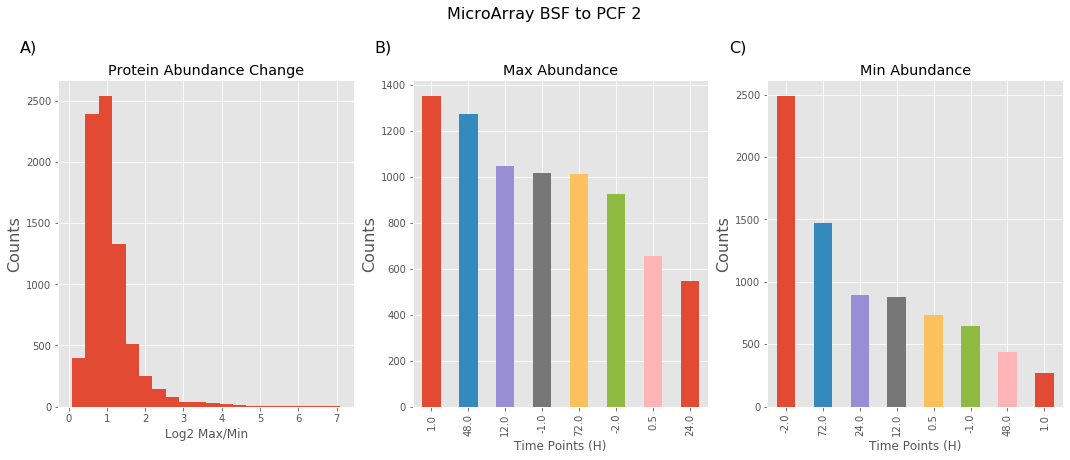

In [29]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_ma_BSF_to_PCF_2_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_ma_BSF_to_PCF_2_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_ma_BSF_to_PCF_2_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('MicroArray BSF to PCF 2',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_8.png'))
plt.show()

In [30]:
print(ml_df.shape)

(11832, 19)


#### DNA microarray BSF to PCF 3
Kabani et al.


PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/19747379 ">19747379</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_b7dc54ebad">TryTripDB</a>

mRNA expression profiles of T. brucei AnTat1.1 slender and stumpy bloodstream stages, as well as 4 time points during the transition of the stumpy to the procyclic life-cycle stage

1. Slender bloodstream form: harvested 3 days post-infection of cyclophosphamide treated mice
2. 0 h time point (Stumpy bloodstream form): harvested 6 days post-infection of cyclophosphamide treated mice
3. 1 h time point: harvested 1 hour after initiating differentiation with cis-aconitate
4. 6 h time point: harvested 6 hour after initiating differentiation with cis-aconitate
5. 18 h time point: harvested 18 hour after initiating differentiation with cis-aconitate
6. 48 h time point: harvested 48 hour after initiating differentiation with cis-aconitate

In [31]:
#set the Slender as the erliest time point
tryp_df.rename({'Slender (Tb LifeCyc Diff Marray)':
                 '-1 Slender (Tb LifeCyc Diff Marray)'},
                inplace=True,axis=1)
cols = [n for n in tryp_df.columns  if 'Tb LifeCyc Diff Marray' in n]
cols

['-1 Slender (Tb LifeCyc Diff Marray)',
 '0 hr (Tb LifeCyc Diff Marray)',
 '1 hr (Tb LifeCyc Diff Marray)',
 '6 hr (Tb LifeCyc Diff Marray)',
 '18 hr (Tb LifeCyc Diff Marray)',
 '48 hr (Tb LifeCyc Diff Marray)']

In [32]:
ml_df['EF_ma_BSF_to_PCF_3_min_max'] = np.log2(
    tryp_df[cols].max(axis=1,skipna=True)/tryp_df[cols].min(axis=1,skipna=True))
ml_df['EF_ma_BSF_to_PCF_3_max'] = tryp_df[cols].idxmax(axis=1)
ml_df['EF_ma_BSF_to_PCF_3_max'] = [float(str(n).split(' ')[0]) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_3_max']]
ml_df['EF_ma_BSF_to_PCF_3_min'] = tryp_df[cols].idxmin(axis=1)
ml_df['EF_ma_BSF_to_PCF_3_min'] = [float(str(n).split(' ')[0]) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_3_min']]

#ml_df['ma_BSF_to_PCF_1_max']=ml_df['ma_BSF_to_PCF_1_max'].astype('category')
#ml_df['ma_BSF_to_PCF_1_min']=ml_df['ma_BSF_to_PCF_1_min'].astype('category')

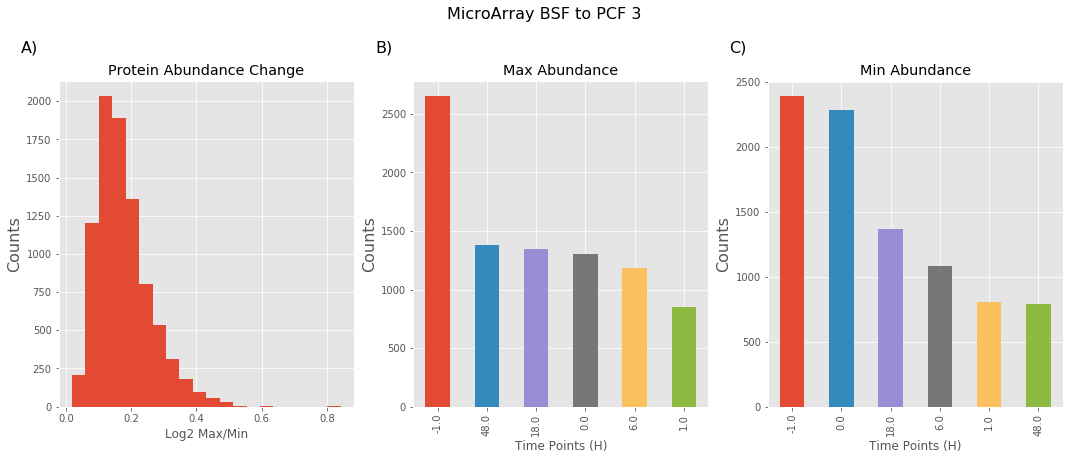

In [33]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_ma_BSF_to_PCF_3_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_ma_BSF_to_PCF_3_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_ma_BSF_to_PCF_3_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('MicroArray BSF to PCF 3',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_9.png'))
plt.show()

### RNA-Seq

#### RNA-Seq mouse blood vs gonadal fat
Trindade S, 2016<p>
Transcriptomes of T brucei parasites isolated from mouse blood and gonadal fat
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/27237364 ">27237364</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_917e265ce7">TryTripDB</a>
    
We also assemble biological descriptors to capture the differential expressed genes between the BSF and ATF (adipose tissue forms) life stages [23]. For this experiment, we computed the log2 fold changes between the ATF and BSF samples.     

In [34]:
#average blood and fat replicates
cols_fat = [n for n in tryp_df.columns  if 'Tbru Adipose RNASeq' in n and 'Fat' in n]
cols_blood = [n for n in tryp_df.columns  if 'Tbru Adipose RNASeq' in n and 'Blood' in n]

tryp_df['fat_mean'] = tryp_df[cols_fat].mean(skipna=True, axis=1)
tryp_df['blood_mean'] = tryp_df[cols_blood].mean(skipna=True, axis=1)
print(tryp_df[['fat_mean','blood_mean']].shape)
#compute FC fat / blood 
ml_df['EF_RNASeq_adipose_blood']=np.log2(tryp_df['fat_mean'].replace(0,np.nan)/tryp_df['blood_mean'].replace(0,np.nan))

(11832, 2)


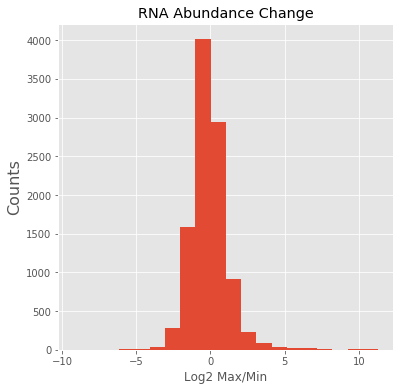

In [35]:
fig,ax=plt.subplots(figsize=(6,6))
ml_df['EF_RNASeq_adipose_blood'].plot(kind='hist', bins=20,ax=ax)
ax.set_xlabel('Log2 Max/Min',fontsize=12)
ax.set_ylabel('Counts', fontsize=16)
ax.set_title('RNA Abundance Change')
#plt.savefig(os.path.join('figures','example_1','Fig_10.png'))
plt.show()

In [36]:
print(ml_df.shape)

(11832, 23)


#### RNA-Seq glucose response
Qiu Y, 2018<p>
RNA seq analysis with or without added glucose and proline/threonine
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/30381351">30381351</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_cf6d4532c7">TryTripDB</a>
   
We also considered the response of the parasites to glucose depletion by computing three features: 1) the log2 fold changes between the RNA-seq read counts of the glucose fed SS BSF parasites versus glucose starved SS  BSF parasites,  2) glucose fed LS BSF parasites versus glucose fed SS  BSF parasites and 3) glucose fed LS BSF parasites versus glucose starved SS  BSF parasites [24]. 

In [37]:
#we used only the fold change in SS
temp_1 = tryp_df['sense - SS + gluc - unique only'].replace(0,np.nan)
temp_2 = tryp_df['sense - SS - gluc - unique only'].replace(0,np.nan)
ml_df['EF_fc_glucose_1'] = np.log2(temp_1/temp_2)

#we used only the fold change in SS
temp_1 = tryp_df['sense - LS + gluc - unique only'].replace(0,np.nan)
temp_2 = tryp_df['sense - SS - gluc - unique only'].replace(0,np.nan)
ml_df['EF_fc_glucose_2'] = np.log2(temp_1/temp_2)

#we used only the fold change in SS
temp_1 = tryp_df['sense - LS + gluc - unique only'].replace(0,np.nan)
temp_2 = tryp_df['sense - SS + gluc - unique only'].replace(0,np.nan)
ml_df['EF_fc_glucose_3'] = np.log2(temp_1/temp_2)


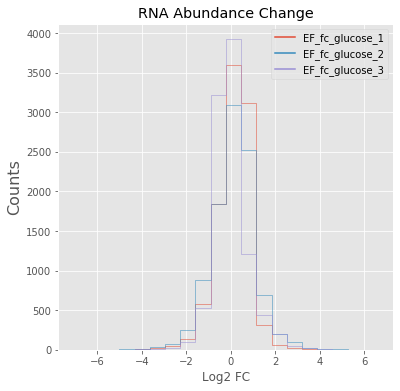

In [38]:
fig,ax=plt.subplots(figsize=(6,6))
ml_df[['EF_fc_glucose_1',
       'EF_fc_glucose_2',
      'EF_fc_glucose_3',]].plot(kind='hist',histtype='step', bins=20,ax=ax)

ax.set_xlabel('Log2 FC',fontsize=12)
ax.set_ylabel('Counts', fontsize=16)
ax.set_title('RNA Abundance Change')
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)

#plt.savefig(os.path.join('figures','example_1','Fig_11.png'))
plt.show()

#### RNA-Seq cell cycle
Archer SK, 2016<p>
Gene expression profiling of the T. brucei cell cycle by RNA-sequencing
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/21483801 ">21483801</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_0de2f64330">TryTripDB</a>

In [39]:
cols = [n for n in tryp_df.columns if 'Tb CellCyc RSeq' in n]
#print (cols)
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_RNA_CellCycle_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))

temp_df.columns = [n.split(' - ')[2].split(' ')[0] for n in cols]
cols = temp_df.columns
ml_df['EF_RNA_CellCycle_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_RNA_CellCycle_max'] = [float(n) for n in ml_df['EF_RNA_CellCycle_max']]
ml_df['EF_RNA_CellCycle_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_RNA_CellCycle_min'] = [float(n) for n in ml_df['EF_RNA_CellCycle_min']] 

#ml_df['RNA_CellCycle_max']=ml_df['RNA_CellCycle_max'].astype('category')
#ml_df['RNA_CellCycle_min']=ml_df['RNA_CellCycle_min'].astype('category')

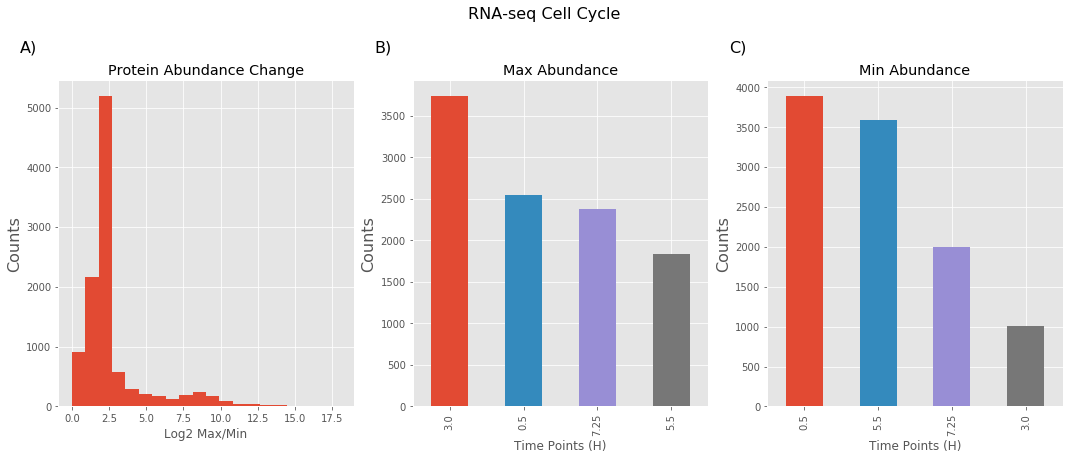

In [40]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_RNA_CellCycle_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_RNA_CellCycle_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_RNA_CellCycle_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')

plt.suptitle('RNA-seq Cell Cycle',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_12.png'))
plt.show()

In [41]:
print(ml_df.shape)

(11832, 29)


#### RNA-seq BSF to PCF

Naguleswaran et al. 2018

PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/29606092">29606092</a> and 
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_b5cbc0fe92">TryTripDB</a>

This study provides the first transcriptomic data from cultures of four consecutive life-cycle stages of Trypanosoma brucei.

In [42]:
tryp_df.rename({'antisense - Long Slender - unique only':
                 '1 antisense - Long Slender - unique only',
               
                'antisense - Short Stumpy - unique only':
                 '2 antisense - Short Stumpy - unique only',
                
                'antisense - PCF Early - unique only':
                 '3 antisense - PCF Early - unique only',

                 'antisense - PCF Late - unique only':
                 '4 antisense - PCF Late - unique only',

               },
                inplace=True,axis=1)

cols = ['1 antisense - Long Slender - unique only', 
        '2 antisense - Short Stumpy - unique only',
        '3 antisense - PCF Early - unique only',
        '4 antisense - PCF Late - unique only']


print (cols)
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_RNA_BSF_to_PCF_anti_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))

temp_df.columns = [n.split(' ')[0] for n in cols]
cols = temp_df.columns
ml_df['EF_RNA_BSF_to_PCF_anti_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_RNA_BSF_to_PCF_anti_max'] = [float(n) for n 
                                       in ml_df['EF_RNA_BSF_to_PCF_anti_max']]
ml_df['EF_RNA_BSF_to_PCF_anti_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_RNA_BSF_to_PCF_anti_min'] = [float(n) for n 
                                       in ml_df['EF_RNA_BSF_to_PCF_anti_min']] 

#ml_df['RNA_CellCycle_max']=ml_df['RNA_CellCycle_max'].astype('category')
#ml_df['RNA_CellCycle_min']=ml_df['RNA_CellCycle_min'].astype('category')

['1 antisense - Long Slender - unique only', '2 antisense - Short Stumpy - unique only', '3 antisense - PCF Early - unique only', '4 antisense - PCF Late - unique only']


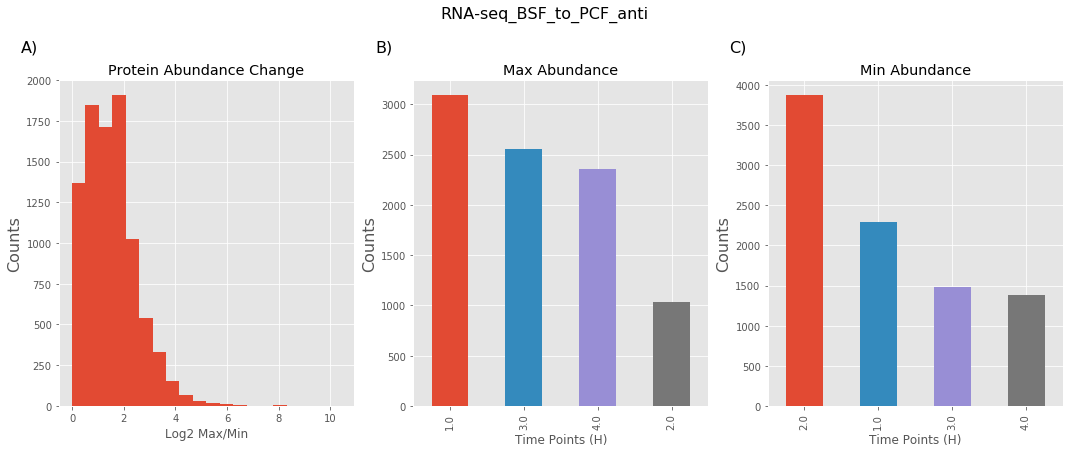

In [43]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_RNA_BSF_to_PCF_anti_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_RNA_BSF_to_PCF_anti_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_RNA_BSF_to_PCF_anti_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')

plt.suptitle('RNA-seq_BSF_to_PCF_anti',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_13.png'))
plt.show()

In [44]:
tryp_df.rename({'sense - Long Slender - unique only':
                 '1 sense - Long Slender - unique only',
               
                'sense - Short Stumpy - unique only':
                 '2 sense - Short Stumpy - unique only',
                
                'sense - PCF Early - unique only':
                 '3 sense - PCF Early - unique only',

                 'sense - PCF Late - unique only':
                 '4 sense - PCF Late - unique only',

               },
                inplace=True,axis=1)

cols = ['1 sense - Long Slender - unique only', 
        '2 sense - Short Stumpy - unique only',
        '3 sense - PCF Early - unique only',
        '4 sense - PCF Late - unique only']



#print (cols)
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_RNA_BSF_to_PCF_sen_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))

temp_df.columns = [n.split(' ')[0] for n in cols]
cols = temp_df.columns
ml_df['EF_RNA_BSF_to_PCF_sen_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_RNA_BSF_to_PCF_sen_max'] = [float(n) for n 
                                      in ml_df['EF_RNA_BSF_to_PCF_sen_max']]
ml_df['EF_RNA_BSF_to_PCF_sen_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_RNA_BSF_to_PCF_sen_min'] = [float(n) for n 
                                      in ml_df['EF_RNA_BSF_to_PCF_sen_min']] 


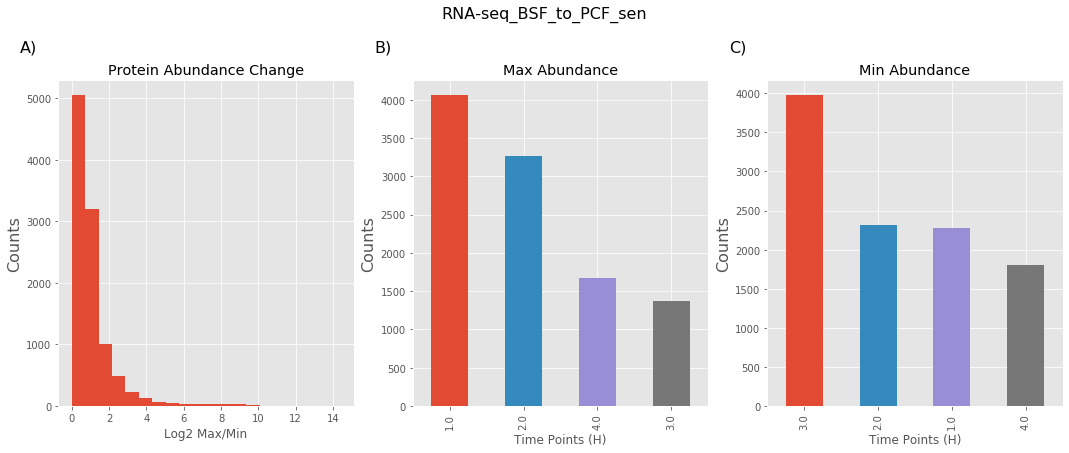

In [45]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_RNA_BSF_to_PCF_sen_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_RNA_BSF_to_PCF_sen_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_RNA_BSF_to_PCF_sen_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')

plt.suptitle('RNA-seq_BSF_to_PCF_sen',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_14.png'))
plt.show()

#### RNA-Seq Abundance
Vasquez JJ, 2014<p>
Procyclic and bloodstream form mRNA transcriptome and ribosome profiling
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/24442674 ">24442674</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_7252b6506e">TryTripDB</a>

In [46]:
#abundace
#[ n for n in X.columns if 'Abundance' in n]
cols = ['sense - PF mRNA', 
            'sense - PF RiboProfile', 
            'sense - BF mRNA',
            'sense - BF RiboProfile',
            ]
new_names = [
'EF_Abundance_s_PCF_mRNA',
'EF_Abundance_s_PCF_Ribo',
'EF_Abundance_s_BSF_mRNA',
'EF_Abundance_s_BSF_Ribo',     
]
temp= tryp_df[cols]
temp= np.log10(temp[cols].replace(0,np.nan))
ml_df[cols]=temp

rename = dict(zip(cols,new_names))
ml_df.rename(rename,axis=1, inplace=True)
ml_df.shape

(11832, 39)

In [47]:
#differential abundace
cols = ['sense - PF mRNA', 
            'sense - PF RiboProfile', 
            'sense - BF mRNA',
            'sense - BF RiboProfile',
            ]
temp= tryp_df[cols]
temp= temp[cols].replace(0,np.nan)
temp['mRNA_BSF_vs_PCF'] = np.log2(temp['sense - BF mRNA']/
                                  temp['sense - PF mRNA'])
temp['RiboP_BSF_vs_PCF'] = np.log2(temp['sense - BF RiboProfile']/
                                   temp['sense - PF RiboProfile'])
ml_df[['EF_mRNA_BSF_vs_PCF',
       'EF_RiboP_BSF_vs_PCF']]=temp[['mRNA_BSF_vs_PCF',
                                     'RiboP_BSF_vs_PCF']]
del temp
gc.collect()
ml_df.shape

(11832, 41)

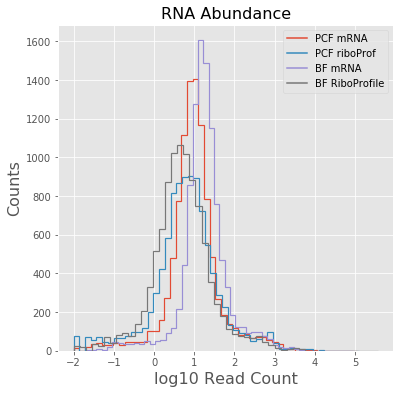

In [48]:
'EF_Abundance_s_PCF_mRNA',
'EF_Abundance_s_PCF_Ribo',
'EF_Abundance_s_BSF_mRNA',
'EF_Abundance_s_BSF_Ribo',

fig,ax=plt.subplots(figsize=(6,6))
from matplotlib.lines import Line2D
ml_df['EF_Abundance_s_PCF_mRNA'].plot(kind='hist',histtype='step', 
                               ax=ax, label='PCF mRNA',linewidth=1.2,bins=50)
ml_df['EF_Abundance_s_PCF_Ribo'].plot(kind='hist',histtype='step',
                                      ax=ax, label='PCF riboProf',
                                      linewidth=1.2,bins=50)
ml_df['EF_Abundance_s_BSF_mRNA'].plot(kind='hist',histtype='step', ax=ax,
                               label='BF mRNA',linewidth=1.2,bins=50)
ml_df['EF_Abundance_s_BSF_Ribo'].plot(kind='hist',histtype='step', 
                                      ax=ax, label='BF RiboProfile',
                                      linewidth=1.2,bins=50)

plt.xlabel('log10 Read Count', fontsize=16)
plt.ylabel('Counts', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)
plt.title('RNA Abundance',fontsize=16)
#plt.savefig(os.path.join('figures','example_1','Fig_15.png'))
plt.show()

In [49]:
import numpy as np
np.log2(10e7)

26.575424759098897

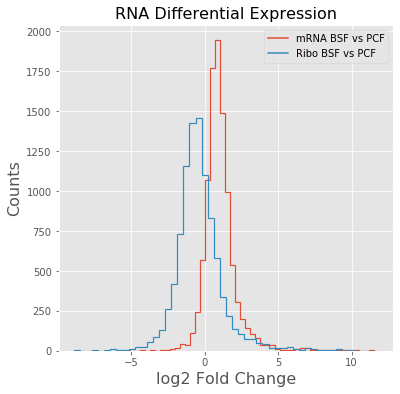

In [50]:
fig,ax=plt.subplots(figsize=(6,6))
from matplotlib.lines import Line2D
ml_df['EF_mRNA_BSF_vs_PCF'].plot(kind='hist',histtype='step', 
                                 ax=ax, label='mRNA BSF vs PCF',
                                 linewidth=1.2,bins=50)
ml_df['EF_RiboP_BSF_vs_PCF'].plot(kind='hist',histtype='step',
                                  ax=ax, label='Ribo BSF vs PCF',
                                  linewidth=1.2,bins=50)
plt.xlabel('log2 Fold Change', fontsize=16)
plt.ylabel('Counts', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)
plt.title('RNA Differential Expression',fontsize=16)
#plt.savefig(os.path.join('figures','example_1','Fig_16.png'))
plt.show()


#### RNA-Seq phenotyping
Alsford S, 2011<p>
High-throughput phenotyping using parallel sequencing of RNA interference targets in the African trypanosome
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/21363968">21363968</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/dataset/DS_3f5188c7a8">TryTripDB</a>
    
We further created a gene lethality descriptor by using the RNA interference (RNAi) high-throughput phenotyping experiment of Alsford S. et al. [25]. From this study, we extracted the log2 fold change of the parasite RNA-seq read counts before and after three days of RNAi induction.     

In [51]:
col = 'BFd3/Tet- (CDS only)'
ml_df['EF_'+col.split('/')[0]]=np.log2(tryp_df[col].replace(0,np.nan))
#The experiment with tags BFd6/Tet-,  PF/Tet-, difn/Tet- 
#['BFd3/Tet- (CDS only)','BFd6/Tet- (CDS only)','PF/Tet- (CDS only)','difn/Tet- (CDS only)']
#contain a mixture of numbers and numbers followed by an asterisks. 
#Don't know why but can't included for now.

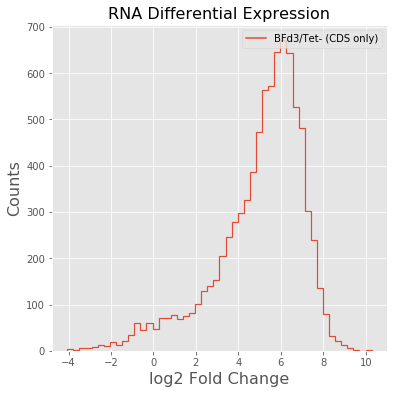

In [52]:
fig,ax=plt.subplots(figsize=(6,6))
from matplotlib.lines import Line2D
ml_df['EF_'+col.split('/')[0]].plot(kind='hist',histtype='step', 
                                        ax=ax, label=col,linewidth=1.2,bins=50)

plt.xlabel('log2 Fold Change', fontsize=16)
plt.ylabel('Counts', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)
plt.title('RNA Differential Expression',fontsize=16)
#plt.savefig(os.path.join('figures','example_1','Fig_17.png'))
plt.show()

## More Computed Features out of creativity

### Signal Peptide
The presence of a signal peptide feature was engineered by averaging the scores of three signal peptide algorithms reported in the TryTripDB CSV file (NN Sum, NN D, HMM Prob), after min max normalization of the scores to distribute the values between 0 and 1. 

In [53]:
#processing of the signal peptide data
from sklearn.preprocessing import minmax_scale
def parse_signal_ip(X):
    if str(X).strip() != str(np.nan):
        temp = [n.strip() for n in X.split(', ')]
        score_a = float(temp[0].split(':')[1].strip())
        score_b = float(temp[1].split(':')[1].strip())   
        score_c = float(temp[2].split(':')[1].strip())
        return score_a,score_b,score_c
    else:
        return 0, 0, 0
temp = pd.DataFrame()
temp["sig_a"], temp["sig_b"], temp["sig_c"] = zip(*tryp_df['SignalP Scores'].apply(
    lambda val: parse_signal_ip(val)))
temp = pd.DataFrame(minmax_scale(temp.values, feature_range =(0,1) ),
                    columns =["sig_a","sig_b","sig_b"], index=temp.index)

ml_df['sig_pep']=temp.sum(axis=1)

In [54]:
tryp_df['SignalP Scores'].dropna().head()

9     NN Sum: 2, NN D: .51, HMM Prob: .09
12    NN Sum: 3, NN D: .49, HMM Prob: .08
13    NN Sum: 3, NN D: .49, HMM Prob: .08
14     NN Sum: 4, NN D: .5, HMM Prob: .13
19    NN Sum: 3, NN D: .59, HMM Prob: .91
Name: SignalP Scores, dtype: object

### Distance from thelomer and position in the polycistronic transcript
The GFF file available in the TriTrypDB database for T. brucei TREU927 was downloaded and analysed to create a descriptor reporting the distance of a gene transcript from its polycystron starting site [31]. Polycystron boundaries were chosen based on changes in transcript orientation. 

In [55]:
#read the gff file and process    
infile=os.path.join('input','TriTrypDB-45_TbruceiTREU927.gff')
source_size = get_source_size(infile=infile)
count=count_comment_line(infile=infile)
gff = pd.read_table(infile,skiprows=count,header=None)
columns = ['seqname','source','feature','start','end',
           'score','strand','frame','attribute']
gff.columns = columns
gff=gff[gff.feature=='gene']
gff['gene_id']=[get_attributes(n)['ID'] for n in gff.attribute]
gff.drop(['attribute','score','frame','source','feature'],inplace=True,axis=1)


gff.sort_values(['seqname','start'],inplace=True)
gff['cds_middle']=(gff['start']+gff['end'])/2
gff['cds_middle']=gff['cds_middle'].astype(int)
gff['cds_lenght']=gff['end']-gff['start']
gff['norm_pos']=[float(a)/source_size[b] for a,b in zip(gff.cds_middle,gff.seqname)]

#shift the dataframe to capture when the genes change plolycistron
gff['strand_shift'] = gff.strand.shift(1)
gff['change']=gff['strand_shift']==gff['strand']

polycistronic_id = []
count=0
for a,b in zip(gff.seqname, gff.change):
    if b:
        polycistronic_id.append(count)
    else:
        polycistronic_id.append(count+1)
        count+=1
gff['polycistron_id'] = [a+'_'+str(b) for a,b in zip(gff.seqname, polycistronic_id)]
temp_g = gff.groupby(['polycistron_id'])
temp_g = temp_g['start'].max()-temp_g['start'].min()
polycistron_sizes = temp_g.to_dict()
gff['polycistron_size']=[polycistron_sizes[n] for n in gff['polycistron_id']]
temp_g = gff.groupby(['polycistron_id'])
gff['polycistron_cds_start']=temp_g['cds_lenght'].cumsum()
gff['polycistron_norm_pos']=gff['polycistron_cds_start']/gff['polycistron_size']
#gff['polycistron_size']=
gff.drop_duplicates(subset=['gene_id'],inplace=True)
gff.set_index('gene_id',inplace=True)
gff[1000:2000].head(10)

,seqname,start,end,strand,cds_middle,cds_lenght,norm_pos,strand_shift,change,polycistron_id,polycistron_size,polycistron_cds_start,polycistron_norm_pos
gene_id,,,,,,,,,,,,,
Tb927.3.1930,Tb927_03_v5.1,508299,509783,-,509041,1484,0.307908,-,True,Tb927_03_v5.1_65,196568,96120,0.488991
Tb927.3.1940,Tb927_03_v5.1,510641,511970,-,511305,1329,0.309277,-,True,Tb927_03_v5.1_65,196568,97449,0.495752
Tb927.3.1955,Tb927_03_v5.1,513487,514034,-,513760,547,0.310762,-,True,Tb927_03_v5.1_65,196568,97996,0.498535
Tb927.3.1960,Tb927_03_v5.1,514271,515762,-,515016,1491,0.311522,-,True,Tb927_03_v5.1_65,196568,99487,0.506120
Tb927.3.1970,Tb927_03_v5.1,516166,517317,-,516741,1151,0.312565,-,True,Tb927_03_v5.1_65,196568,100638,0.511975
Tb927.3.1980,Tb927_03_v5.1,517473,518492,-,517982,1019,0.313316,-,True,Tb927_03_v5.1_65,196568,101657,0.517159
Tb927.3.1990,Tb927_03_v5.1,518617,520892,-,519754,2275,0.314388,-,True,Tb927_03_v5.1_65,196568,103932,0.528733
Tb927.3.2000,Tb927_03_v5.1,521498,522203,-,521850,705,0.315656,-,True,Tb927_03_v5.1_65,196568,104637,0.532320
Tb927.3.2010,Tb927_03_v5.1,522343,524255,-,523299,1912,0.316532,-,True,Tb927_03_v5.1_65,196568,106549,0.542047


In [56]:
#add the new features
print(ml_df.shape)
ml_df=ml_df.join(gff[[#'norm_pos', 'polycistron_cds_start',
                      'polycistron_norm_pos']], how='left', on='Gene ID')
print(ml_df.shape)

(11832, 43)
(11832, 44)


In [57]:
#tryp_df['# TM Domains']

In [58]:
#Anoter normalization for the trans-membrane domain
ml_df['tm_1']=tryp_df['# TM Domains']/tryp_df['Transcript Length']
ml_df['Transcript Length'] = np.log(tryp_df['Transcript Length'])

#Normalization of the SNPs data
for c in [
    'Non-Coding SNPs All Strains',
    'NonSyn/Syn SNP Ratio All Strains', 
    'NonSynonymous SNPs All Strains', 
    'SNPs with Stop Codons All Strains', 
    'Synonymous SNPs All Strains', 
    'Total SNPs All Strains']:
    ml_df[c]=tryp_df[c]/tryp_df['Transcript Length']

### More feature from TritrypDB 

The next columns / sequence features do not need preprocessing, we just transfer these features to our ML dataset

The changes in RNA abundance after overexpressing the wild type RNA helicase DHH1, or after expressing a mutant form of this protein, have been investigating with a cDNA microarrays strategy [26]. The dataset is reported in TriTrypDB as the log2 fold changes signal intensity between the wild type versus the experimentally induced conditions. For this reason, the dataset was transferred over the ML dataset without further processing. A similar cDNA microarray strategy was used to study the T. brucei response to Heat shock [27] and the log2 fold change between the wild type and treated condition was transferred over to the ML dataset. So it was the log2 fold change values of the protein abundance (evaluated with label-free mass spectrometry) between the PCF nuclei and the whole-cell lysates [28]. All the features added so far derive from experimental evidences, for this reason the names are preceded by the ‘EF’ (Experimental Feature) prefix for easier identification.

In [59]:
cols =[
    #experiment features
    'DEAD:DQAD mutant - DHH1 mutant induced vs control (Tb427 DHH1 induced)',
    'heatShock_vs_control (heat shock treated)',
    'wild type - wild type induced vs control (Tb427 DHH1 induced)',
    'Nuclear Enriched Sample (Tb927 Nuc Prot)',

    #sequence features
    'Ortholog count',
    'Paralog count',]


rename = {
    'DEAD:DQAD mutant - DHH1 mutant induced vs control (Tb427 DHH1 induced)':
    'EF_DHH1_mutant',
    
    'heatShock_vs_control (heat shock treated)':
    'EF_heatShock',
    
    'wild type - wild type induced vs control (Tb427 DHH1 induced)':
    'EF_DHH1_induced',
    
    'LS (Tb927 LSvSS QProt)':'EF_LS_QProt',
    'SS (Tb927 LSvSS QProt)':'EF_SS_QProt',
    
    'Nuclear Enriched Sample (Tb927 Nuc Prot)':
    'EF_Nuclear_enriched',}


ml_df[cols]=tryp_df[cols]
ml_df.rename(rename, axis=1, inplace=True)

ml_df.shape

(11832, 58)

In [60]:
ml_df.head()

,Gene ID,EF_merged_PCF_BSF,EF_SS_QProt,EF_CellCycle_min_max,EF_CellCycle_max,EF_CellCycle_min,EF_Abundance_BSF,EF_Abundance_PCF,EF_MW_fc,EF_in_complex,...,NonSynonymous SNPs All Strains,SNPs with Stop Codons All Strains,Synonymous SNPs All Strains,Total SNPs All Strains,EF_DHH1_mutant,EF_heatShock,EF_DHH1_induced,EF_Nuclear_enriched,Ortholog count,Paralog count
0,Tb04.24M18.150,0.402849,NaN,0.000000,0.5,0.5,5.870638,7.631146,229.805303,-1.0,...,0.034765,0.000000,0.010225,0.044990,-0.36,-1.21,-0.12,NaN,57,1
1,Tb04.3I12.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.0,...,0.028668,0.001686,0.013491,0.045531,NaN,0.52,NaN,NaN,0,0
2,Tb05.30F7.410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.0,...,0.001706,0.000000,0.000244,0.025341,NaN,-1.08,NaN,NaN,0,0
3,Tb05.5K5.10,NaN,NaN,NaN,NaN,NaN,7.606765,7.829130,0.000000,-1.0,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,43,1
4,Tb05.5K5.100,NaN,NaN,0.263034,11.0,10.0,6.758570,7.772565,20.888992,-1.0,...,0.001563,0.000000,0.001563,0.003125,0.13,-1.27,0.07,NaN,7,1


In [61]:
#[n for n in ml_df.columns if 'heatShock' in n]

### Coding transcripts

In [62]:
#adding binary value, protein coding or not
def get_prop(desc):
    desc=desc.split('|')
    desc = [n.strip().split('=') for n in desc][1:]
    desc = dict(zip([n[0] for n in desc],[n[1] for n in desc]))
    return(desc['gene'])
      
infile=os.path.join('input','TriTrypDB-45_TbruceiTREU927_AnnotatedProteins.fasta')
handle = open(infile, "rU")
prot_cod = []
for record in SeqIO.parse(handle, "fasta"):
    #print(record.id)
    prot_cod.append(get_prop(record.description))
prot_cod=set(prot_cod)  
ml_df['prot_coding']=[1 if n in prot_cod else 0 for n in ml_df['Gene ID']]
ml_df['prot_coding'].value_counts()

1    11203
0      629
Name: prot_coding, dtype: int64

## Sequence Based Features

### ProFET 
(https://github.com/ddofer/ProFET)
We further complemented our ML dataset by using the ProFET package to extracts hundreds of features covering the elementary biophysical and sequence-derived attributes of the T. brucei proteome [30]. 

In [5]:
fasta_file = os.path.join('input',
                          'TriTrypDB-45_TbruceiTREU927_AnnotatedProteins.fasta')

instances = len([n for n in SeqIO.parse(fasta_file, 'fasta')])
print(instances)

11203


In [6]:
#create a list of sequence,id to compute in parallel 
compute_list = []
for index,record in tqdm_notebook(
    enumerate(SeqIO.parse(fasta_file, 'fasta')), total=instances ):
        sequence = str(record.seq)
        temp_id = record.id
        compute_list.append((sequence,temp_id))        

#### Multiprocessing

In [7]:
#the code run only if the profet output file is 
#not present in the input folder

#time to use some machine power
#this is a workaround to do 
#multiprocessing using notebooks on windows
from mylib import get_features
import time
import multiprocessing as mp
cores = mp.cpu_count()
print('using', cores, 'cores')
if __name__=="__main__":
    if not os.path.exists(os.path.join('input','profet.csv.gz')):
        start_time = time.time()
        
        p = mp.Pool(cores)
        function_results = p.map(get_features.compute, compute_list)
        p.close()
        print("--- %s seconds ---" % (time.time() - start_time))

        function_results = pd.concat(function_results, axis=1)
        function_results = function_results.T
        function_results.dropna(axis=0,how ='all',inplace=True)
        function_results.to_csv(os.path.join('input','profet.csv.gz'), compression='gzip')
        print(function_results.head())

using 12 cores


#### one core

In [13]:
if not os.path.exists(os.path.join('input','profet.csv.gz')):
    function_results = [get_features.compute(n) for n in tqdm_notebook(compute_list)]
    function_results = pd.concat(function_results, axis=1)
    function_results = function_results.T
    function_results.dropna(axis=0,how ='all',inplace=True) 
    function_results.to_csv(os.path.join('input','profet.csv.gz'), compression='gzip') 
    function_results.head() 

In [66]:
def prepare_profet(infile=os.path.join('input','profet.csv.gz')):
    df = pd.read_csv(infile)
    df['Gene ID'] = [clean_id(n) for n in df['protein']]
    df.drop_duplicates(subset=['Gene ID'],inplace=True)
    df.set_index('Gene ID',inplace=True,drop=True)
    del df['protein']
    #we now remove sequence features with high correlation
    df_corr = df.corr().abs()
    upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
    df.drop(to_drop,axis=1,inplace=True)
    return df


temp =  prepare_profet()
#already present in the output of TriTrypDB
del temp['Molecular Weight']
#final_df.drop(temp.columns,axis=1,inplace=True)
temp.columns = ['AF_'+n for n in temp.columns]
print(ml_df.shape)
ml_df=ml_df.join(temp, how='left', on='Gene ID')
print(ml_df.shape)

(11832, 59)
(11832, 1118)


### ELM linear motif

Finally, from the ELM database [32], we downloaded the eukaryotic linear motifs, and we create a descriptor for each linear motif, reporting the number of motif instances in the primary sequence of the T. brucei proteome. With this final step, we ended up with a ML dataset of 1407 descriptors. 

In [67]:
import re

def find_motif(prot,motif):
    return len(motif.findall(prot))

infile=os.path.join('input', 'elm_classes.tsv')
count=count_comment_line(infile=infile, tag='#')
elm = pd.read_table(infile,skiprows=count)
elm.head()
elm_dict = {}
for r,s in zip(elm.ELMIdentifier, elm.Regex):
    elm_dict[r]=re.compile(s)

motif_dict={}
infile=os.path.join('input',
                    'TriTrypDB-45_TbruceiTREU927_AnnotatedProteins.fasta')
handle = open(infile, "rU")    
for record in SeqIO.parse(handle, "fasta"):
    temp_id = clean_id (record.id)
    seq = str(record.seq)
    res = [find_motif(seq, motif) for motif in elm_dict.values()]
    #print (res)
    motif_dict[temp_id]=res

motif_dict = pd.DataFrame.from_dict(motif_dict,orient='index')           
motif_dict.head()
motif_dict.columns = elm_dict.keys()

motif_dict['ELM_CLV'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('CLV')]].sum(axis=1)
motif_dict['ELM_DEG'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('DEG')]].sum(axis=1)
motif_dict['ELM_DOC'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('DOC')]].sum(axis=1)
motif_dict['ELM_LIG'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('LIG')]].sum(axis=1)
motif_dict['ELM_MOD'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('MOD')]].sum(axis=1)
motif_dict['ELM_TRG'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('TRG')]].sum(axis=1)
motif_dict.head()

,CLV_C14_Caspase3-7,CLV_MEL_PAP_1,CLV_NRD_NRD_1,CLV_PCSK_FUR_1,CLV_PCSK_KEX2_1,CLV_PCSK_PC1ET2_1,CLV_PCSK_PC7_1,CLV_PCSK_SKI1_1,CLV_Separin_Fungi,CLV_Separin_Metazoa,...,TRG_NLS_MonoExtN_4,TRG_Pf-PMV_PEXEL_1,TRG_PTS1,TRG_PTS2,ELM_CLV,ELM_DEG,ELM_DOC,ELM_LIG,ELM_MOD,ELM_TRG
Tb927.1.05,4,0,3,0,2,1,0,5,0,0,...,1,1,0,0,15,1,14,37,58,3
Tb927.1.1000,2,0,1,0,3,2,0,11,0,0,...,0,0,0,0,19,2,15,53,42,9
Tb927.1.100,0,0,6,1,3,0,1,7,0,2,...,0,1,0,0,20,3,20,69,57,16
Tb927.1.1010,3,0,4,1,4,2,1,13,0,0,...,0,1,0,0,28,3,39,94,88,10
Tb927.1.1020,2,0,1,0,1,0,0,4,0,1,...,0,1,0,0,9,1,11,57,54,9


In [68]:
#add the features
print(ml_df.shape)
motif_dict.columns = [n if n.startswith('ELM_') else 'ELM_'+n for n in motif_dict.columns]

ml_df=ml_df.join(motif_dict, how='left', on='Gene ID')
print(ml_df.shape)

(11832, 1118)
(11832, 1403)


### Finalize dataset

In [69]:
ml_df.head()
#cast the values onto smaller size
ml_df = scripts.reduce_mem_usage(ml_df)

Memory usage of dataframe is 126.65 MB



Memory usage after optimization is: 63.72 MB
Decreased by 49.7%


In [70]:
ml_df=ml_df.drop_duplicates('Gene ID')

#save for later
ml_df.to_csv(os.path.join('output', 'final_df.csv.gz'), compression='gzip')

In [71]:
#uncomment if you start from here
#ml_df=pd.read_csv(os.path.join('output','final_df.gz'))
#ml_df.head()